# Description

## Context:
AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the bank poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customers queries are resolved faster. The Head of Marketing and the Head of Delivery both decide to reach out to the Data Science team for help.

**Objective** : To identify different segments in the existing customer based on their spending patterns as well as past interaction with the bank.

**Dataset**:  ALLLife bank

**Data Description**: Data is of various customers of a bank with their credit limit, the total number of credit cards the customer has, and different channels through which customer has contacted the bank for any queries, different channels include visiting the bank, online, and through a call center.

Apply the concepts and techniques you have learned in the previous weeks and summarize your insights at the end.

## **Key Questions:**
* Perform EDA.
* Apply Clustering Algorithms and mentions how many clusters are formed ?
* How are these segments different from each other?
* What are your recommendations to the bank on how to better market to and service these customers?


**Submission Guidelines**:

You need to submit a python notebook in both ".ipynb and HTML" format.
Any assignment found copied/ plagiarized with other groups will not be graded and awarded zero marks.
Please ensure timely submission as any submission post-deadline will not be accepted for evaluation.
Submission will not be evaluated if either it is submitted post-deadline or more than 2 files are submitted.


### Happy Learning!

In [1]:
# gets rid of a k-means memory leak warning message later.
import os

os.environ["OMP_NUM_THREADS"] = "1"

In [2]:
# import libraries section
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy
import statistics
import warnings
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage

%matplotlib inline

In [3]:
# other global options
np.set_printoptions(suppress = True)  # To avoid unnecessary engineering notation use later.
#warnings.filterwarnings("ignore")  # I got the notebook to work without this on my machine, but uncomment if you get an irksome error.
plt.rcParams["axes.formatter.useoffset"] = False
pd.options.display.html.use_mathjax = False # Removes '$ sign as italics' issue.
pd.options.display.max_columns = None # To stop suppressing the middle columns when viewing a wide dataframe.

## Define the problem and perform an Exploratory Data Analysis

### Problem definition

Try to find meaningful groupings of customers in order to provide better customer service to those groups.

### Questions to be answered

What are the relationships between average credit limit, total credit cards, total visits to the bank, total visits online, and total calls made?

### Data background and contents

In [4]:
input_file = 'Credit Card Customer Data.xlsx'
data = pd.read_excel(input_file)
data.head().style.hide_index()

Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
1,87073,100000,2,1,1,0
2,38414,50000,3,0,10,9
3,17341,50000,7,1,3,4
4,40496,30000,5,1,1,4
5,47437,100000,6,0,12,3


In [5]:
# SI_No and Customer Key are not useful variables for this analysis, so I'll make a new dataframe "df" that drops them.
df = data.drop(columns=['Sl_No', 'Customer Key'])
df.head().style.hide_index()

Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
100000,2,1,1,0
50000,3,0,10,9
50000,7,1,3,4
30000,5,1,1,4
100000,6,0,12,3


In [6]:
# shape
df.shape

(660, 5)

Univariate analysis

In [7]:
# check datatype
df.dtypes

Avg_Credit_Limit       int64
Total_Credit_Cards     int64
Total_visits_bank      int64
Total_visits_online    int64
Total_calls_made       int64
dtype: object

In [8]:
#statistical summary
df.describe()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,660.000000,660.000000,660.000000,660.000000,660.000000
mean,34574.242424,4.706061,2.403030,2.606061,3.583333
std,37625.487804,2.167835,1.631813,2.935724,2.865317
min,3000.000000,1.000000,0.000000,0.000000,0.000000
25%,10000.000000,3.000000,1.000000,1.000000,1.000000
50%,18000.000000,5.000000,2.000000,2.000000,3.000000
75%,48000.000000,6.000000,4.000000,4.000000,5.000000
max,200000.000000,10.000000,5.000000,15.000000,10.000000


In [9]:
def my_numeric_univariate_analysis_function(my_col, input_dataframe = df):
    print("Now considering the variable {0}...\n".format(my_col))
    # Boxplot
    g = sns.boxplot(data = input_dataframe, x = my_col)
    plt.ticklabel_format(style='plain', axis='x')
    plt.xticks(rotation=30)
    plt.show()
    
    # Histplot
    f = plt.figure()
    ax = f.add_subplot(111)
    plt.ticklabel_format(style='plain', axis='x')
    sns.despine(offset=10, left=True, right=False)

    # I moved the y-axis and label to the right because I wanted to roughly line up the boxplot with the hist plot
    ax.yaxis.tick_right()
    ax.yaxis.set_ticks_position('right')
    ax.yaxis.set_label_position('right')
    sns.histplot(data = input_dataframe, x = my_col)
    plt.xticks(rotation=30)
    plt.show()
    
    # Mean and median comparison
    median = np.nanmedian(input_dataframe[my_col]) 
    mean = np.mean(input_dataframe[my_col])
        
    if mean > median:
        mean_above_median_msg = "bigger than the"
    elif mean == median:
        mean_above_median_msg = "equal to the"
    elif mean < median:
        mean_above_median_msg = "less than the"
    else:
        raise NameError('mean_above_median_msg_error')
        
    msg1 = "\nThe mean is {x_bar}, which is {mean_relation_to_median} median value of {x_tilde}.".format(x_bar = round(mean, 3), mean_relation_to_median = mean_above_median_msg, x_tilde = median)
    print(msg1)
    
    
    # skewness
    skew_value = np.array([np.ma.getdata(scipy.stats.skew(a = input_dataframe[my_col], nan_policy = 'omit'))])[0]
    
    # skewness rule of thumb
    # source:  http://brownmath.com/stat/shape.htm#SkewnessInterpret
    if abs(skew_value) > 1:
        skewness_interpretation = 'highly skewed'
    elif abs(skew_value) > .5:
        skewness_interpretation = 'moderately skewed'
    elif skew_value == 0:
        skewness_interpretation = 'exactly symmetric'
    else:  #value is between -.5 and .5 (except for 0)
        skewness_interpretation = 'approximately symmetric'
        
    msg2 = "The skewness of the distribution is {value} which is considered to be {interpretation}.".format(value = round(skew_value, 3), interpretation = skewness_interpretation)
    print(msg2)
    
    if "skew" in skewness_interpretation:  # This is to handle these two cases:  'moderately skewed', 'highly skewed'
        if skew_value > 0:
            
            skew_direction = 'left'
        else:
            skew_direction = 'right'
        msg3 = "This variable is {skew_direction}-skewed.  End of univariate analysis for this {var} variable.".format(skew_direction = skew_direction, var = my_col)
    else:
        msg3 = "End of univariate analysis for this variable, {var}.".format(var = my_col)
        
    print(msg3)
    print("-------------------------------------------------------------------------------\n\n")

Now considering the variable Avg_Credit_Limit...



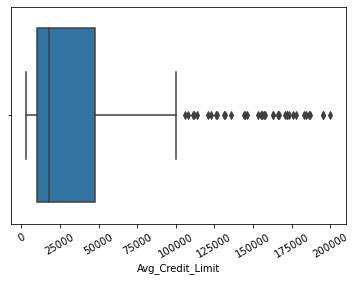

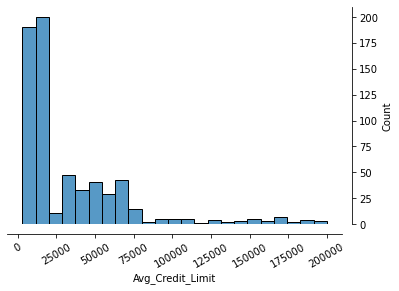


The mean is 34574.242, which is bigger than the median value of 18000.0.
The skewness of the distribution is 2.197 which is considered to be highly skewed.
This variable is left-skewed.  End of univariate analysis for this Avg_Credit_Limit variable.
-------------------------------------------------------------------------------


Now considering the variable Total_Credit_Cards...



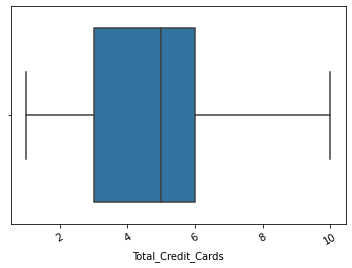

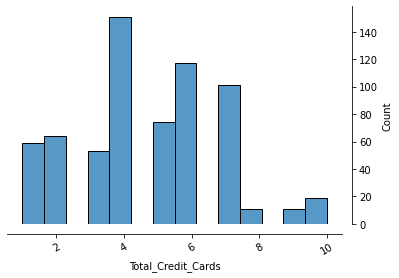


The mean is 4.706, which is less than the median value of 5.0.
The skewness of the distribution is 0.145 which is considered to be approximately symmetric.
End of univariate analysis for this variable, Total_Credit_Cards.
-------------------------------------------------------------------------------


Now considering the variable Total_visits_bank...



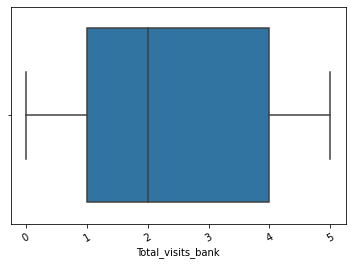

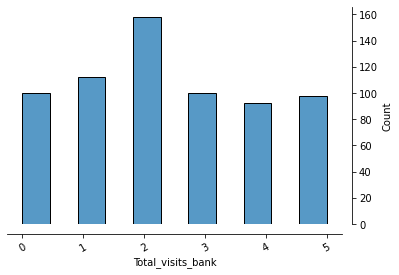


The mean is 2.403, which is bigger than the median value of 2.0.
The skewness of the distribution is 0.142 which is considered to be approximately symmetric.
End of univariate analysis for this variable, Total_visits_bank.
-------------------------------------------------------------------------------


Now considering the variable Total_visits_online...



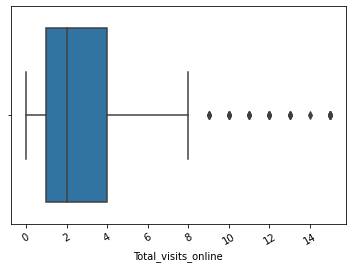

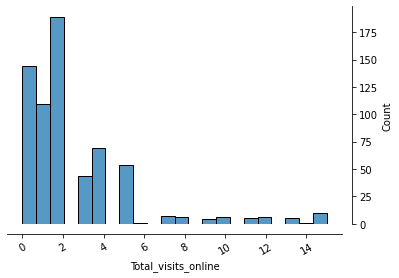


The mean is 2.606, which is bigger than the median value of 2.0.
The skewness of the distribution is 2.221 which is considered to be highly skewed.
This variable is left-skewed.  End of univariate analysis for this Total_visits_online variable.
-------------------------------------------------------------------------------


Now considering the variable Total_calls_made...



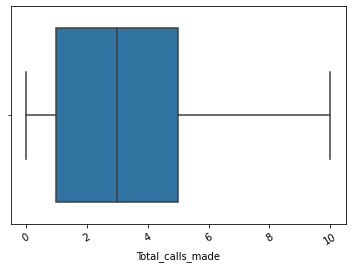

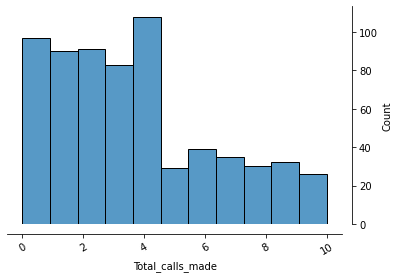


The mean is 3.583, which is bigger than the median value of 3.0.
The skewness of the distribution is 0.657 which is considered to be moderately skewed.
This variable is left-skewed.  End of univariate analysis for this Total_calls_made variable.
-------------------------------------------------------------------------------




In [10]:
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()

for col in numeric_cols:
    my_numeric_univariate_analysis_function(my_col = col, input_dataframe = df)

In [11]:
# looking for unique values
   # Columns with all unique values are individual identifiers and should have no generalizable predictive power.
   # Columns with only two unique values are bernoulli variables. 
sorted_dataframe = pd.DataFrame(df.nunique().sort_values(ascending = False)).rename(columns={0:'number of values'})
display(sorted_dataframe)

# This series of if-else statements only looks for 1 hit of each.  (Will want to look at displayed dataframe
#    to see if there are multiple key variables, monotone variables, or bernouilli variables.
#    If so, will want to recode this for multiple matches.)
if sorted_dataframe.iloc[0,0] == len(df):
    print(sorted_dataframe.index[0] + " is a unique key variable.")
else:
    print("There are no key variables here.")
if sorted_dataframe.iloc[-1,0] == 1:
    print(sorted_dataframe.index[-1] + "has no uniqueness and should be dropped.")
elif sorted_dataframe.iloc[-1,0] == 2:
    print(sorted_dataframe.index[-1] + "is a Bernoulli variable.")

,number of values
Avg_Credit_Limit,110
Total_visits_online,16
Total_calls_made,11
Total_Credit_Cards,10
Total_visits_bank,6


There are no key variables here.


Bivariate analysis

In [12]:
# This is stripped down from my normal bivariate function that runs a t-test and makes summaries.
# This function handles bivariate analysis.  (Default parameters for this y_var and this input_dataframe)
def my_bivariate_analysis_function(x_var, y_var, input_dataframe = df):
    sns.set(rc={'figure.figsize':(21,7)})
    
    print("Now considering the variable {0} vs {1}...\n".format(x_var, y_var))
    
    # If it is a numeric variable, execute a violinplot bivariate analysis.
    if str(input_dataframe[x_var].dtype) == 'float64' or str(df[x_var].dtype) == 'int64':
        col1 = x_var
        col2 = y_var
        data = input_dataframe
        #sns.catplot(x=col1, y=col2, kind='violin', data=data);
        #sns.scatterplot(data=data, x=col1, y=col2)
        sns.boxplot(data=data, x=col1, y=col2)
        plt.show()
        
    # If it is a non-numeric variable, 
    elif str(input_dataframe[x_var].dtype) == 'category' or str(input_dataframe[x_var].dtype) == 'object':
        col1 = x_var
        col2 = y_var
        data = df
        sns.catplot(hue=col1, x=col2, kind='count', data=data)
        plt.show()
    
    # Just here in case I encounter a different dtype in the future.
    else:
        print("This variable has a different dtype.  It is {x}.".format(x = str(input_dataframe[x_var].dtype)))  
    print("-------------------------------------------------------------------------------\n\n")

In [13]:
# Taking a look at all the variables.
print("Here are the variables:")
for var in df.columns:
    print('\t', var)

Here are the variables:
	 Avg_Credit_Limit
	 Total_Credit_Cards
	 Total_visits_bank
	 Total_visits_online
	 Total_calls_made


This is the 'y' variable:
Avg_Credit_Limit


These are the 'x' variables:
['Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online', 'Total_calls_made']
Now considering the variable Total_Credit_Cards vs Avg_Credit_Limit...



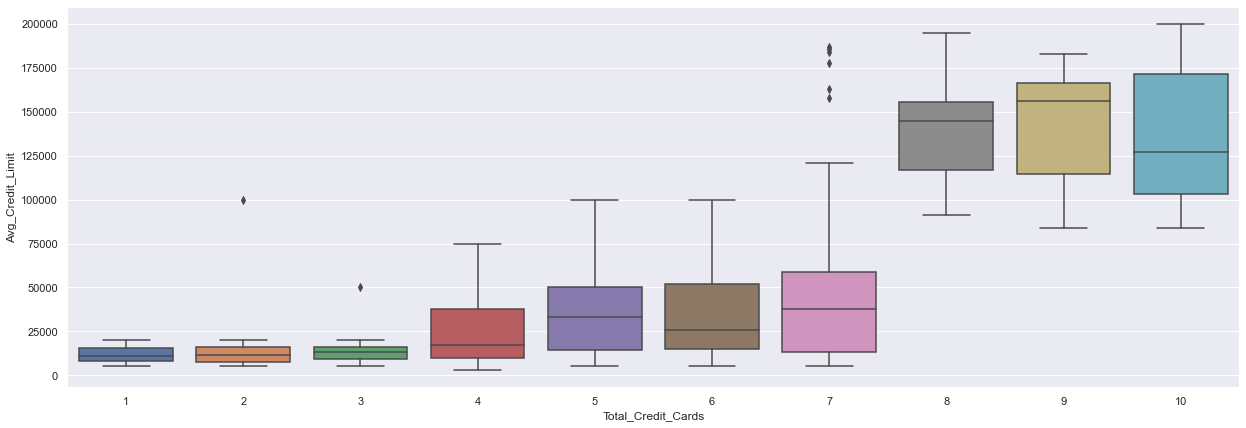

-------------------------------------------------------------------------------


Now considering the variable Total_visits_bank vs Avg_Credit_Limit...



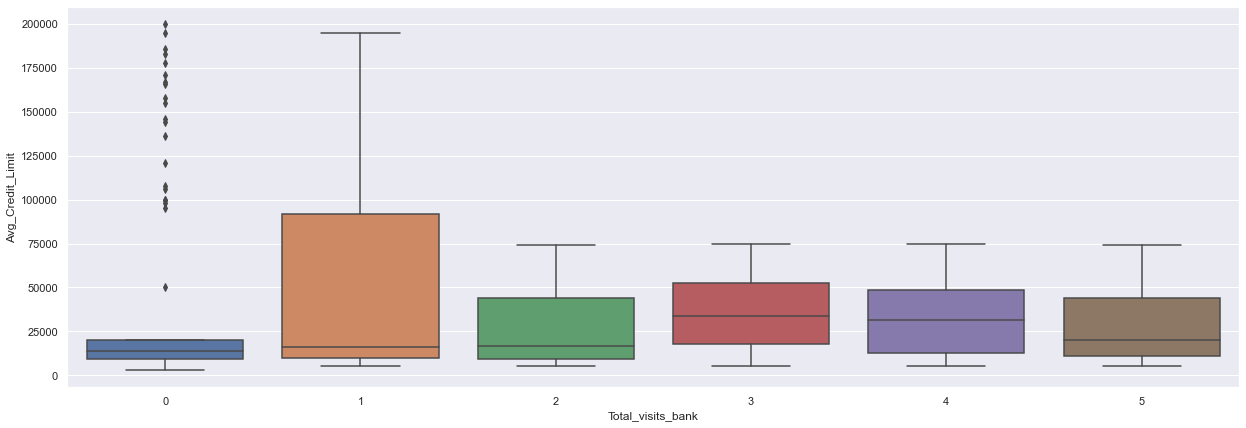

-------------------------------------------------------------------------------


Now considering the variable Total_visits_online vs Avg_Credit_Limit...



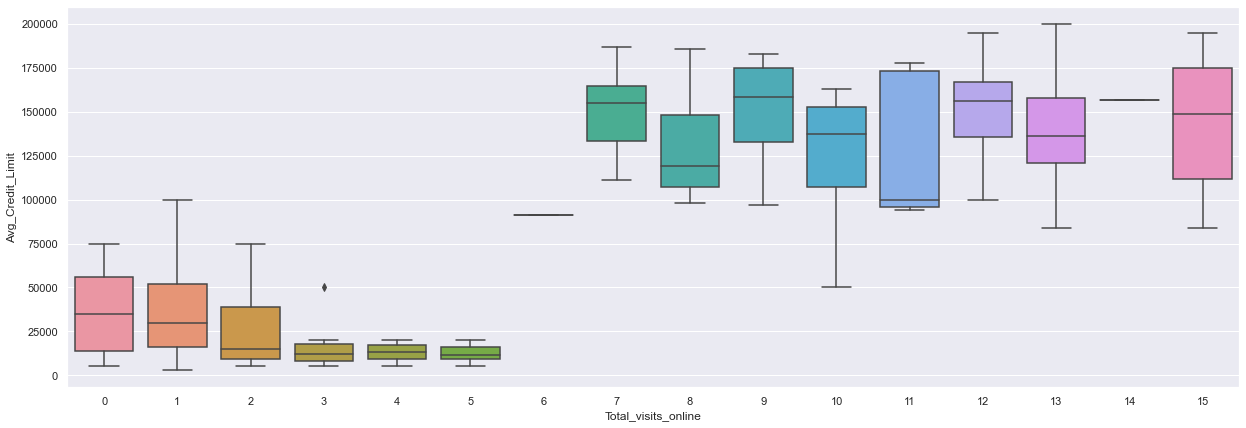

-------------------------------------------------------------------------------


Now considering the variable Total_calls_made vs Avg_Credit_Limit...



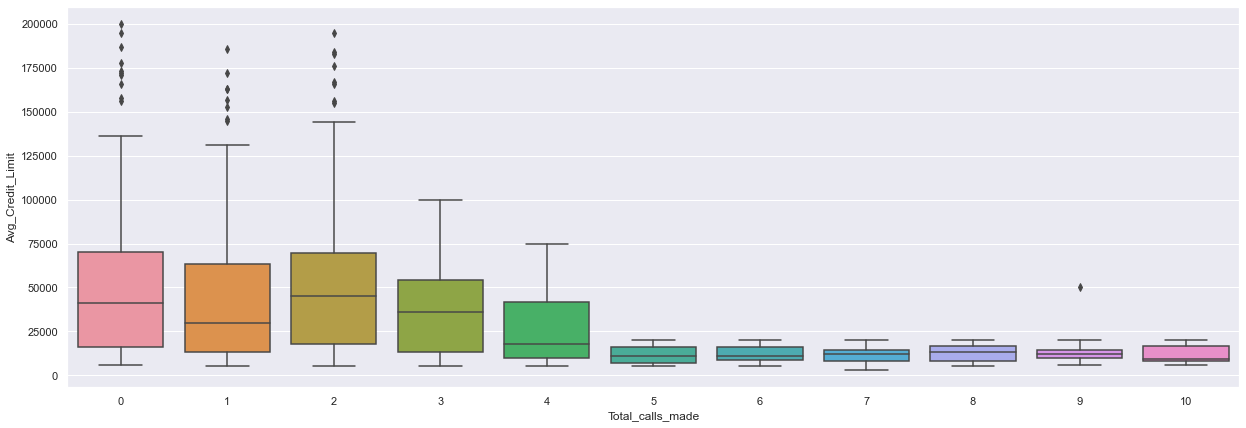

-------------------------------------------------------------------------------


This is the 'y' variable:
Total_Credit_Cards


These are the 'x' variables:
['Total_visits_bank', 'Total_visits_online', 'Total_calls_made']
Now considering the variable Total_visits_bank vs Total_Credit_Cards...



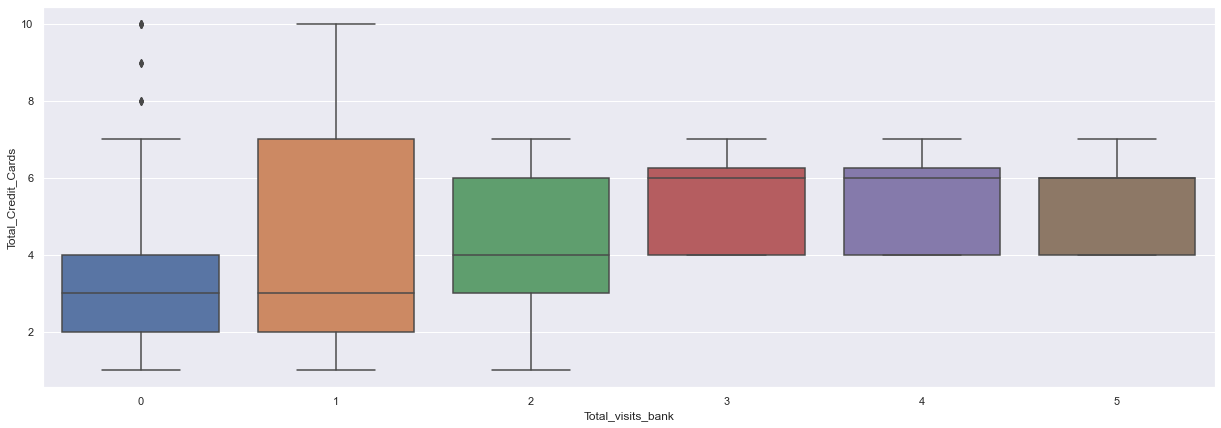

-------------------------------------------------------------------------------


Now considering the variable Total_visits_online vs Total_Credit_Cards...



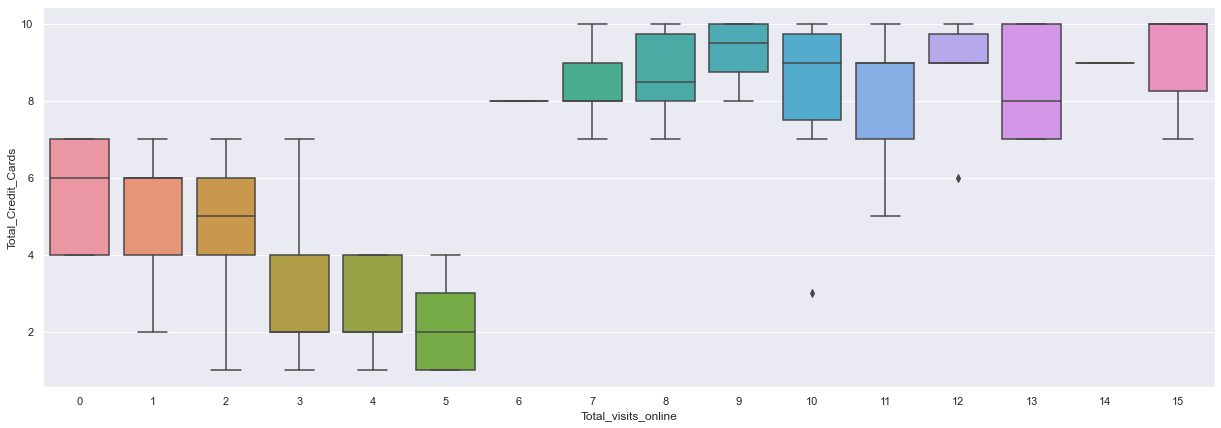

-------------------------------------------------------------------------------


Now considering the variable Total_calls_made vs Total_Credit_Cards...



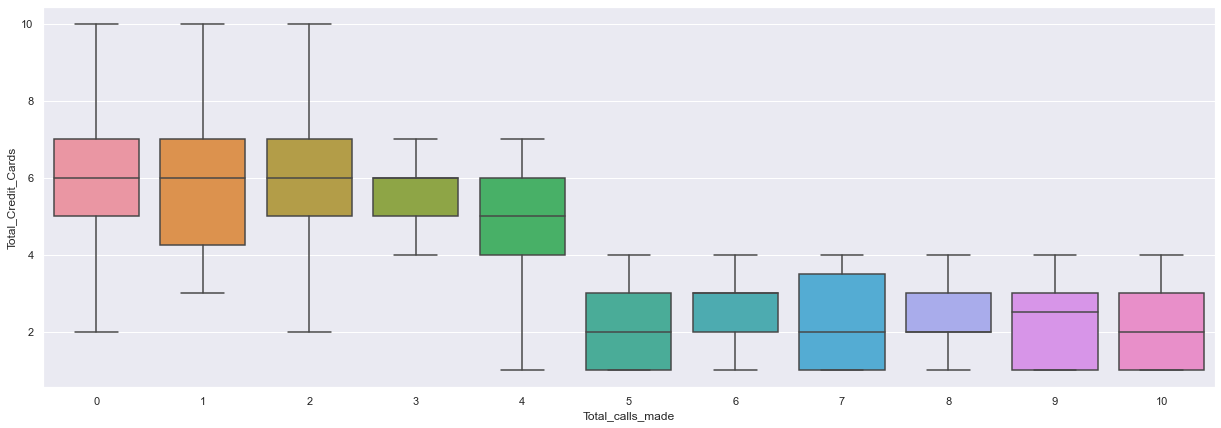

-------------------------------------------------------------------------------


This is the 'y' variable:
Total_visits_bank


These are the 'x' variables:
['Total_visits_online', 'Total_calls_made']
Now considering the variable Total_visits_online vs Total_visits_bank...



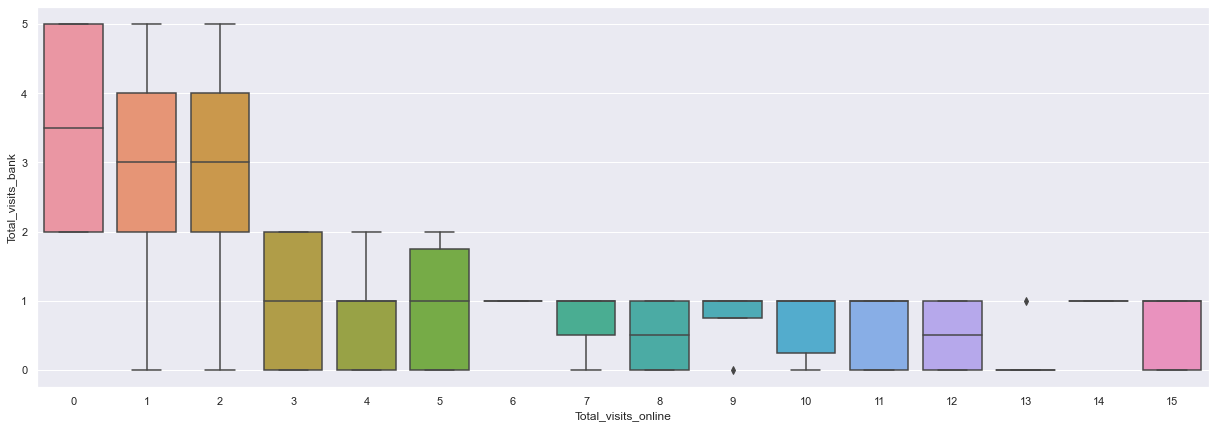

-------------------------------------------------------------------------------


Now considering the variable Total_calls_made vs Total_visits_bank...



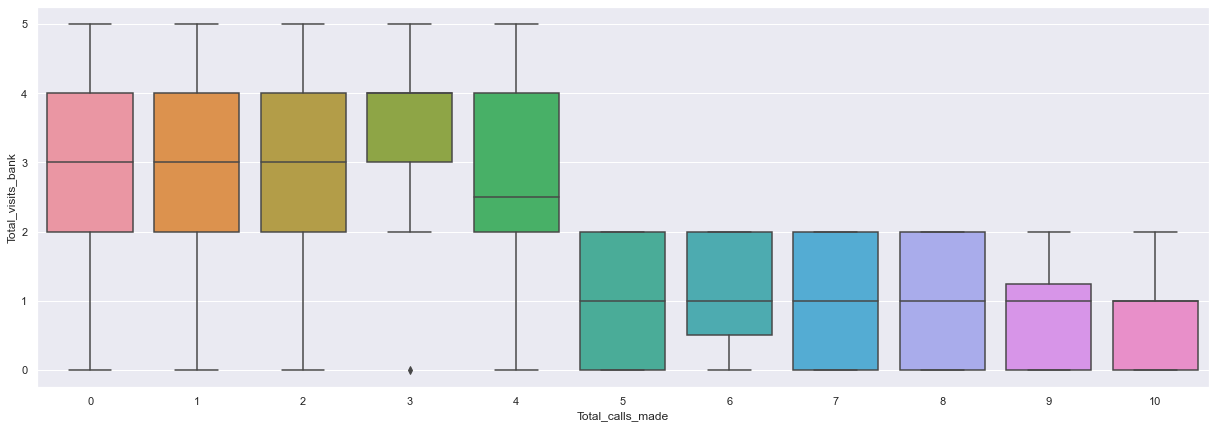

-------------------------------------------------------------------------------


This is the 'y' variable:
Total_visits_online


These are the 'x' variables:
['Total_calls_made']
Now considering the variable Total_calls_made vs Total_visits_online...



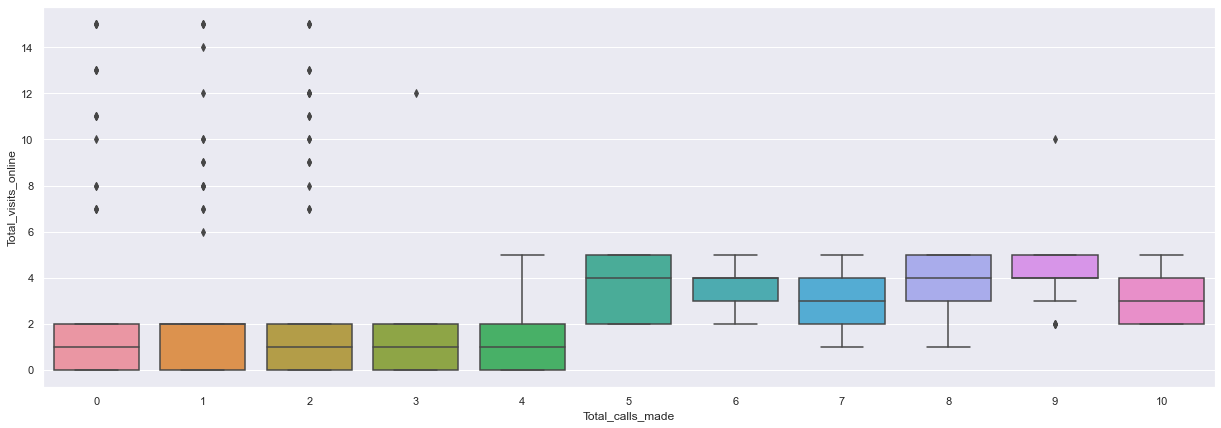

-------------------------------------------------------------------------------




In [14]:
# In this step I'm cycling through all the variables so that each gets a bivariate comparison with every other variable.

#  For example,
#  a vs b; a vs c; a vs d; a vs e;
#          b vs c; b vs d; b vs e;
#                  c vs d; c vs e;
#                          d vs e;

x_variables = df.columns.to_list()  # Gets all variables from dataframe

for i in range(df.shape[1]-1):
    y_variable = df.columns[i]
    print("This is the 'y' variable:")
    print(y_variable)
    print('\n')
    
    x_variables.remove(y_variable)      # removes the dependent variable
    print("These are the 'x' variables:")
    print(x_variables)                  # Now we have just the x's.
    for x_var in x_variables:
        my_bivariate_analysis_function(x_var, y_var = y_variable)

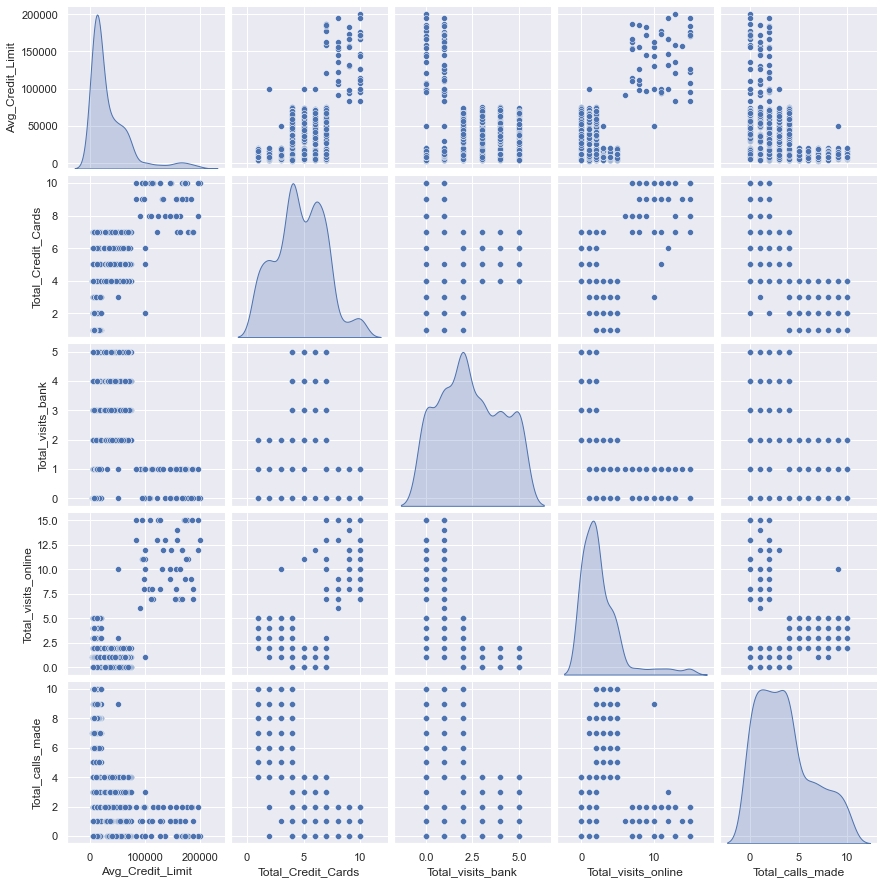

In [15]:
sns.pairplot(df, diag_kind='kde');

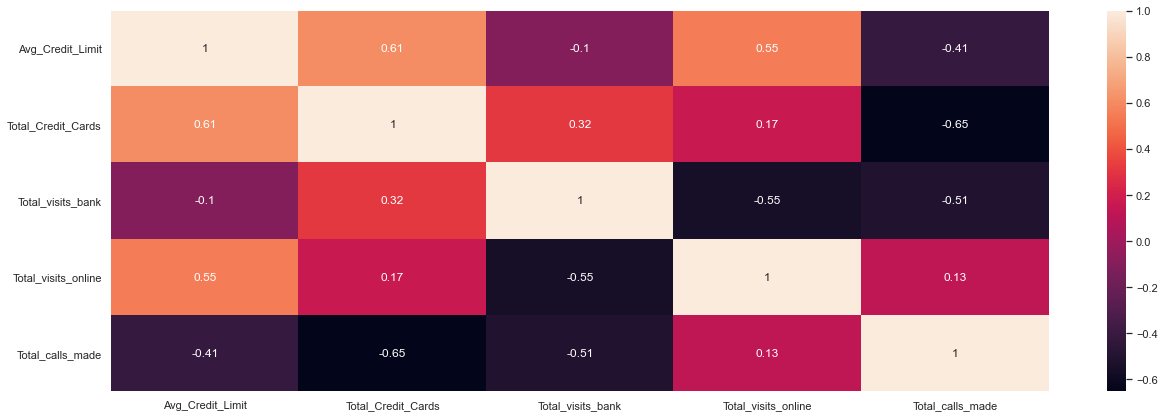

In [16]:
sns.heatmap(df.corr(), annot=True);

## Illustrate the insights based on EDA
Key meaningful observations on individual variables and the relationship between variables

- For total visits online vs total credit cards, there is an inflection point at 6+ credit cards where the customers start making more online visits than customers did before that sixth credit card.  In fact, there appeared to be a negative relationship between total credit cards and total visits between 0 credit cards and 5 credit cards until the jump disontinuity at 6.
- There is an inverse relationship between the number of bank vists and the number of online visits a customer makes.
- Likewise, there is an inverse relationship between the number of bank vists and the number of calls a customer makes.
- There is another grouping of customers in total visits online vs avg credit limit:  Those with lower credit limits make much less online visits.
- Back from the univariate analysis, there aren't that many customers with > 100,000 average credit limit.

## Data pre-processing
Prepare the data for analysis

In [17]:
# Scaling the dataset before clustering
scaler = StandardScaler()
subset = df.copy()
scaled_df = pd.DataFrame(scaler.fit_transform(subset), columns = df.columns)

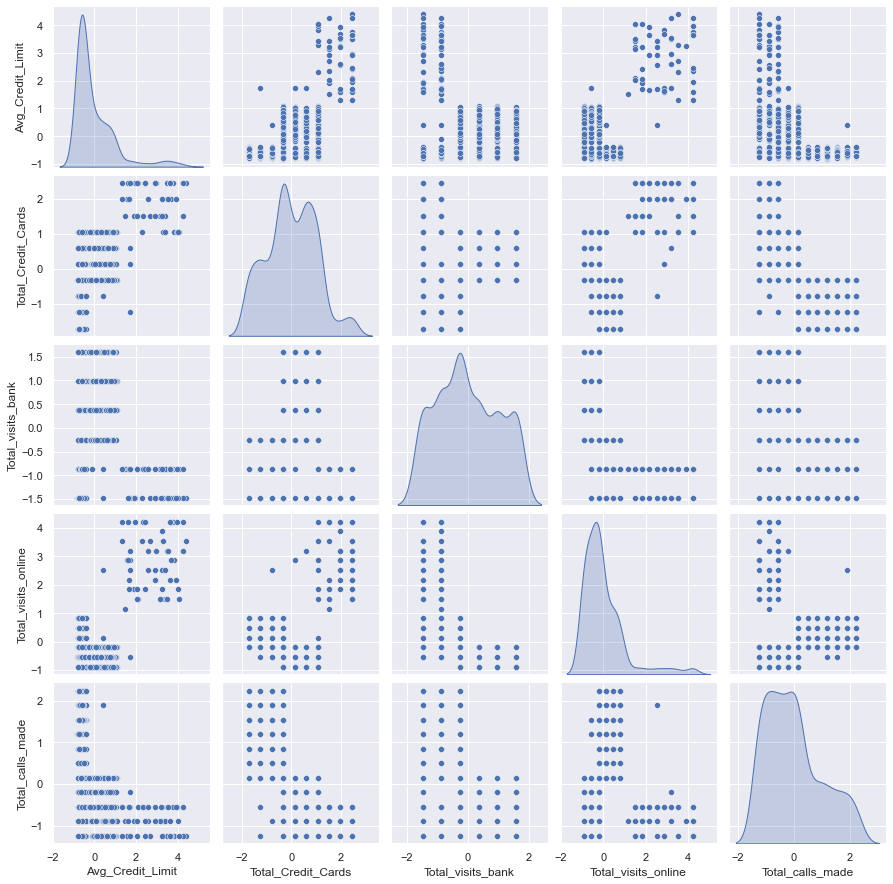

In [18]:
# Just checking to make sure the scaling worked.
sns.pairplot(scaled_df, diag_kind='kde');

### Feature Engineering

I did not see any examples of feature engineering in this unsupervised learning module.<br>
In the future, if I'd like to attempt it, I did find this reference.<br>
https://www.datasciencecentral.com/profiles/blogs/feature-engineering-for-building-clustering-models

### Missing value Treatment

In [19]:
# looking for na values
sorted_dataframe = pd.DataFrame(scaled_df.isna().sum().sort_values(ascending = False)).rename(columns={0:'number of values'})

if sorted_dataframe.iloc[0,0] == 0:
    print("There are no missing values in this dataframe.\n")
else:
    print("There are some missing values in this dataframe.\n")
    
display(sorted_dataframe)

There are no missing values in this dataframe.



,number of values
Avg_Credit_Limit,0
Total_Credit_Cards,0
Total_visits_bank,0
Total_visits_online,0
Total_calls_made,0


### Outlier Treatment

I don't think there are any extreme outliers, so, for now, I'm going to just let it ride with the outliers.

Duplicate observations check and removal if found

In [20]:
# I'll look to see if there are any duplicates in this scaled data frame.
scaled_df[scaled_df.duplicated(keep=False)].sort_values(by='Avg_Credit_Limit')

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
310,-0.786612,-0.325946,1.592670,-0.88838,-0.902271
395,-0.786612,-0.325946,1.592670,-0.88838,-0.902271
56,-0.760014,-1.710864,-1.473731,-0.20660,0.494794
175,-0.760014,-1.710864,-1.473731,-0.20660,0.494794
385,-0.706819,1.058973,0.979390,-0.20660,-1.251537
334,-0.706819,1.058973,0.979390,-0.20660,-1.251537
17,-0.706819,-1.249225,-1.473731,0.13429,0.145528
215,-0.706819,-0.325946,-1.473731,0.47518,1.193326
162,-0.706819,-1.249225,-1.473731,0.13429,0.145528
29,-0.706819,-0.325946,-1.473731,0.47518,1.193326


It looks like there are a few.<br>
However, in order for me to think that these are problematic duplicates (as in, keying errors), I would expect to see them next to each other in either the SI_No or the Customer_Key.<br>
That would mean that they were double-entered right after each other somehow, and then I would want to remove one of them.

In [21]:
data[data.duplicated(subset=['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online', 'Total_calls_made'], keep=False)].sort_values(by='Avg_Credit_Limit')

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
310,311,83459,5000,4,5,0,1
395,396,31515,5000,4,5,0,1
56,57,32828,6000,1,0,2,5
175,176,20524,6000,1,0,2,5
385,386,16418,8000,7,4,2,0
334,335,41159,8000,7,4,2,0
17,18,96463,8000,2,0,3,4
215,216,18609,8000,4,0,4,7
162,163,80457,8000,2,0,3,4
29,30,29112,8000,4,0,4,7


Not one of these duplicated entries is directly adjacent in the SI_No or in the Customer_Key values.  Therefore, I think these duplicates are legitimate due to  business rules of the bank.  (For instance, customer 465 and customer 498 both have the same credit limit, but it's likely, if our bank didn't require values to be rounded to a thousand, that customer 465 may have warranted 51,750 dollars in credit while customer 498 should have been granted 52,250 dollars.  However, we don't have that capability, and so they both get rounded to the nearest thousand instead.

## Applying K-means clustering algorithms
Apply K-means

In [22]:
# From GreatLearning's "K-means.ipynb"
#Finding optimal no. of clusters

clusters=range(1,10)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(scaled_df)
    prediction=model.predict(scaled_df)
    meanDistortions.append(sum(np.min(cdist(scaled_df, model.cluster_centers_, 'euclidean'), axis=1)) / scaled_df.shape[0])

Elbow curve

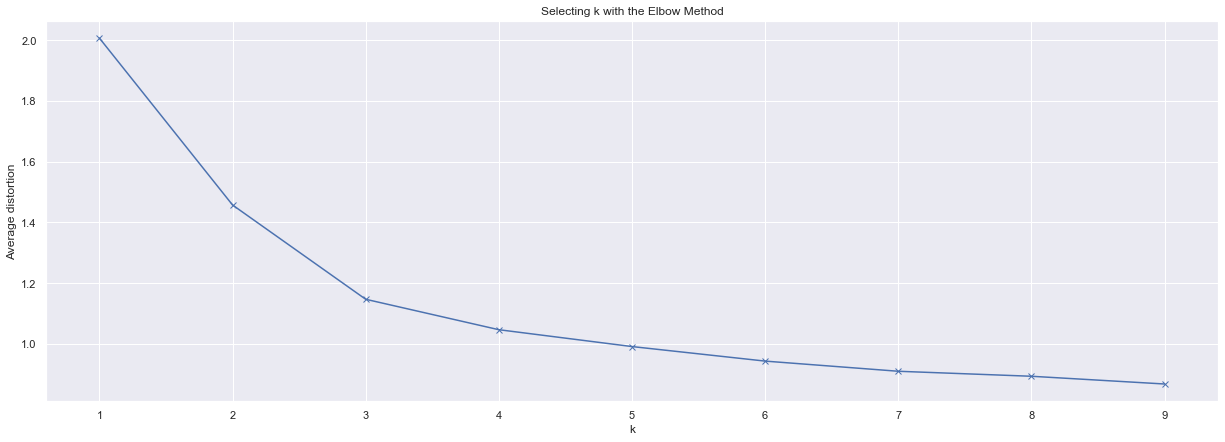

In [23]:
plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')
plt.show()

Silhouette Score

For n_clusters = 2, silhouette score is 0.41842496663215445)
For n_clusters = 3, silhouette score is 0.5157182558881063)
For n_clusters = 4, silhouette score is 0.3556670619372605)
For n_clusters = 5, silhouette score is 0.2717470361089752)
For n_clusters = 6, silhouette score is 0.2554668170859757)
For n_clusters = 7, silhouette score is 0.24787934301251532)
For n_clusters = 8, silhouette score is 0.22825912543572954)
For n_clusters = 9, silhouette score is 0.2246286888318386)


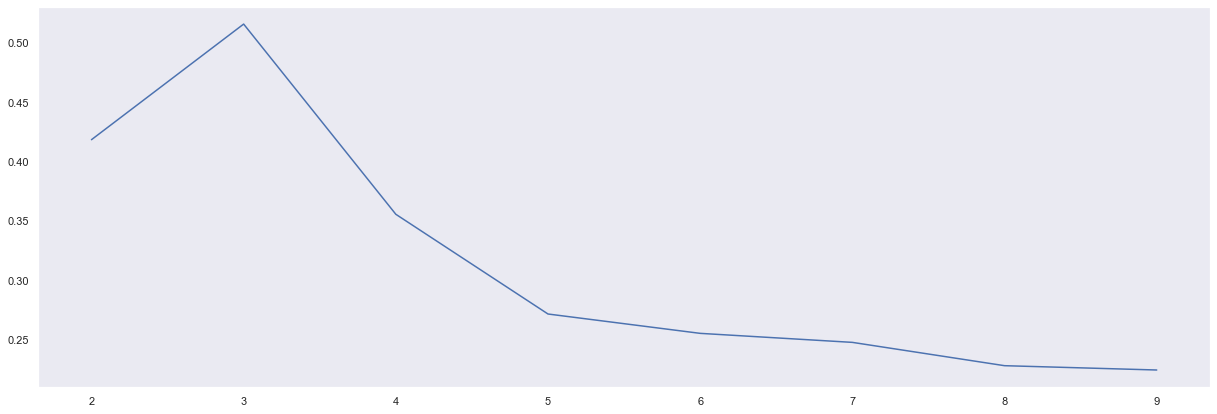

In [24]:
# From GreatLearning's "Additional Case Study Week _1"
sil_score = []
cluster_list = list(range(2,10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((scaled_df))
    #centers = clusterer.cluster_centers_
    score = silhouette_score(scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

plt.plot(cluster_list,sil_score)
plt.grid()

Figure out appropriate number of cluster

In [25]:
kmeans_cluster_number = 3

I will choose 3 as the appropriate number of clusters.  The elbow on the elbow chart is at k=3, and the highest point on the silhouette chart also occurs when k=3.

## Applying Hierarchical clustering

#### Apply Hierarchical clustering with different linkage methods & plot dendrograms for each linkage method
###### (I combined these two sub-steps)

In [26]:
possible_linkages = ['single', # and ready to mingle
                    'complete',
                    'average',
                    'weighted',
                    'centroid',
                     'median',
                    'ward']


The value of c for this single linkage type is 0.7391220243806552.



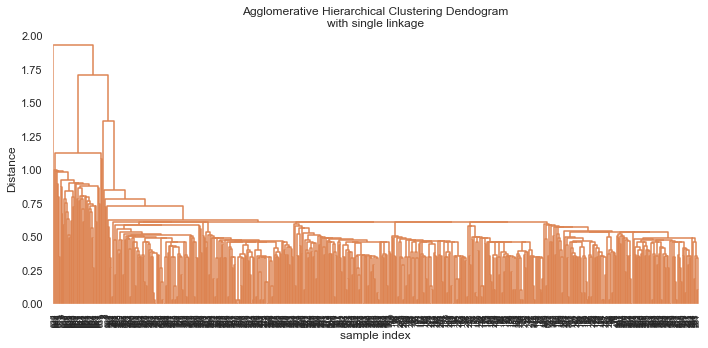


The value of c for this complete linkage type is 0.8599730607972423.



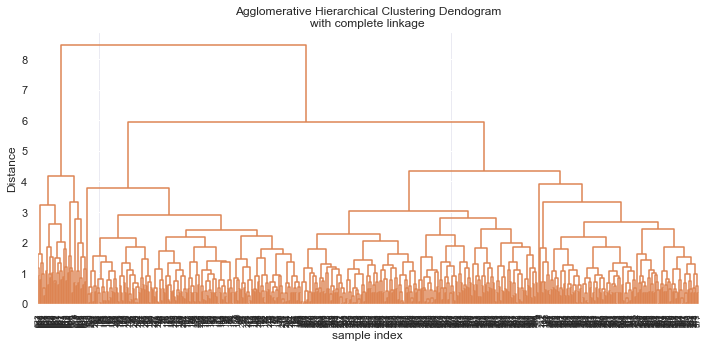


The value of c for this average linkage type is 0.8977080867389372.



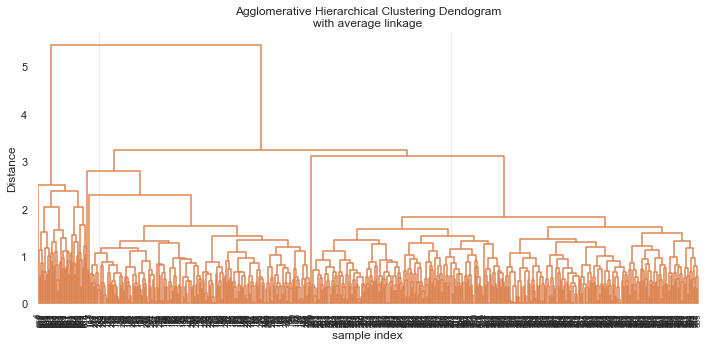


The value of c for this weighted linkage type is 0.8861746814895477.



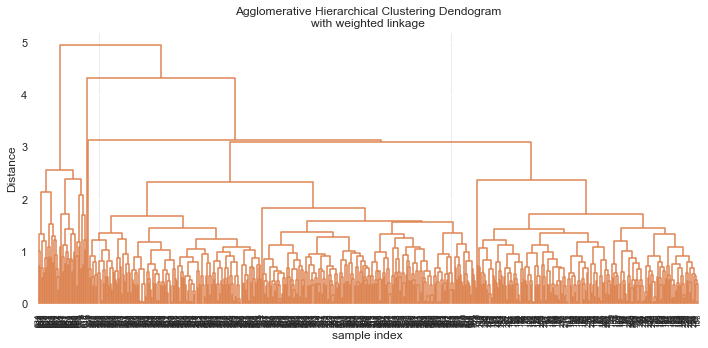


The value of c for this centroid linkage type is 0.8939385846326323.



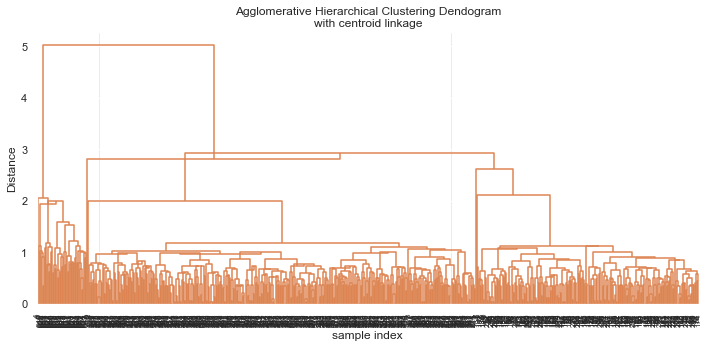


The value of c for this median linkage type is 0.8893799537016724.



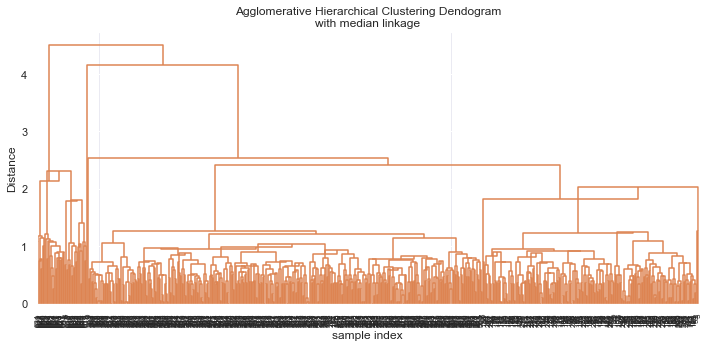


The value of c for this ward linkage type is 0.7415156284827493.



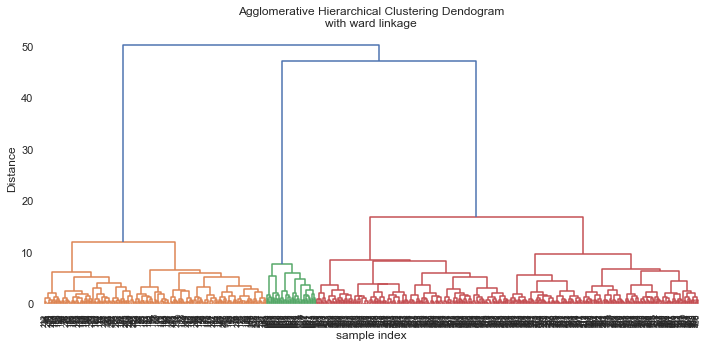

In [27]:
c_list = []
for linkage_type in possible_linkages:
    Z = linkage(scaled_df, metric='euclidean', method=linkage_type)
    c, coph_dists = cophenet(Z , pdist(scaled_df))
    c_list.append(c)
    print("\nThe value of c for this {linkage_type} linkage type is {c}.\n".format(linkage_type=linkage_type, c = str(c)))
    
    plt.figure(figsize=(10, 5))
    plt.title('Agglomerative Hierarchical Clustering Dendogram\n'
          + 'with {linkage_type} linkage'.format(linkage_type=linkage_type))
    plt.xlabel('sample index')
    plt.ylabel('Distance')
    dendrogram(Z, leaf_rotation=90.,color_threshold = 40, leaf_font_size=8. )
    plt.tight_layout()
    plt.show()

In [28]:
c_value_df = pd.DataFrame({'linkage_type':possible_linkages, 'c_value':c_list})
print("Here are the linkage types with their corresponding cophnenex index values.\n")
display(c_value_df.sort_values(by='c_value', ascending=False).style.hide_index())
max_c_value = c_value_df['c_value'].max()
best_linkage_type = c_value_df.loc[c_value_df['c_value'] == max_c_value, 'linkage_type'].iloc[0]
print("\nThe one with the highest cophnenex index value is the {} linkage type.".format(best_linkage_type))

Here are the linkage types with their corresponding cophnenex index values.



linkage_type,c_value
average,0.897708
centroid,0.893939
median,0.889380
weighted,0.886175
complete,0.859973
ward,0.741516
single,0.739122



The one with the highest cophnenex index value is the average linkage type.


Re-examining the average linkage type....

The value of c for this average linkage type is 0.8977080867389372.



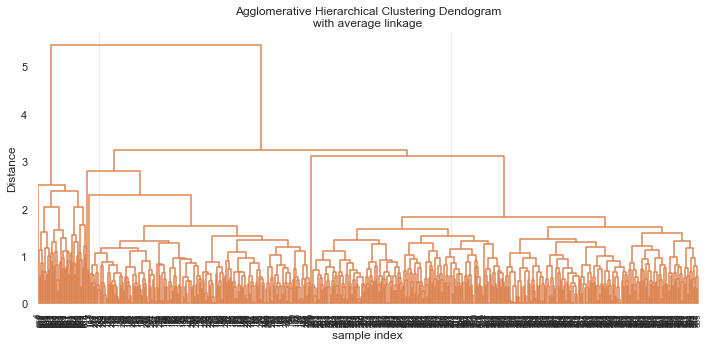

In [29]:
print("Re-examining the {} linkage type....".format(best_linkage_type))

for linkage_type in [best_linkage_type]:
    Z = linkage(scaled_df, metric='euclidean', method=linkage_type)
    c, coph_dists = cophenet(Z , pdist(scaled_df))
    print("\nThe value of c for this {linkage_type} linkage type is {c}.\n".format(linkage_type=linkage_type, c = str(c)))
    
    plt.figure(figsize=(10, 5))
    plt.title('Agglomerative Hierarchical Clustering Dendogram\n'
          + 'with {linkage_type} linkage'.format(linkage_type=linkage_type))
    plt.xlabel('sample index')
    plt.ylabel('Distance')
    dendrogram(Z, leaf_rotation=90.,color_threshold = 40, leaf_font_size=8. )
    plt.tight_layout()
    plt.show()

### Choose an appropriate number of clusters

In [30]:
hier_cluster_number = 2

Going off the logic and intuition explained on pages 392-393 of <u>An Introduction to Statistical Learning with Applications in R</u>, I'm going to go with 2 clusters.

## Compare cluster K-means clusters and Hierarchical clusters
Perform cluster profiling

In [31]:
features = df.columns.to_list()[0:5]

In [32]:
# Following blocks of code modified from GreatLearning's 'MLS1 - Engineering College.ipynb'
kmeans = KMeans(n_clusters=kmeans_cluster_number, random_state=4)
kmeans.fit(scaled_df[features])

KMeans(n_clusters=3, random_state=4)

In [33]:
segment_col_of_interest = 'K_means_segments'
needed_cols = list(features + [segment_col_of_interest])

df[segment_col_of_interest] = kmeans.labels_
cluster_profile = df[needed_cols].groupby(segment_col_of_interest).mean()
# Since this is a count, it doesn't really matter which column is chosen.  I therefore generalized this code.
cluster_profile['count_in_each_segment'] = df[needed_cols].groupby(segment_col_of_interest)[df[needed_cols].columns[0]].count().values

display(cluster_profile)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
K_means_segments,,,,,,
0,12174.107143,2.410714,0.933036,3.553571,6.870536,224
1,141040.000000,8.740000,0.600000,10.900000,1.080000,50
2,33782.383420,5.515544,3.489637,0.981865,2.000000,386


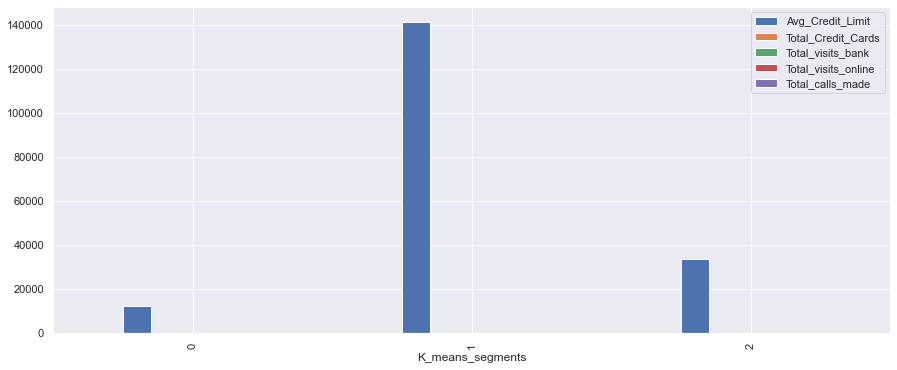

In [34]:
df[needed_cols].groupby(segment_col_of_interest).mean().plot.bar(figsize=(15,6));

From this, we can really only make comments on the credit limit.  Due to its sheer magnitude, it crowds out the others.

We can see that segment 1 is for the 'high rollers'; segment 2, 'medium rollers'; segment 0, 'credit constrained.'

So, I will do a simple rescaling of just that Avg Credit limit variable by dividing it by 10,000 in order to see everything at the same time.

In [35]:
df['credit_limit_by_10k'] = df['Avg_Credit_Limit'] / 10000

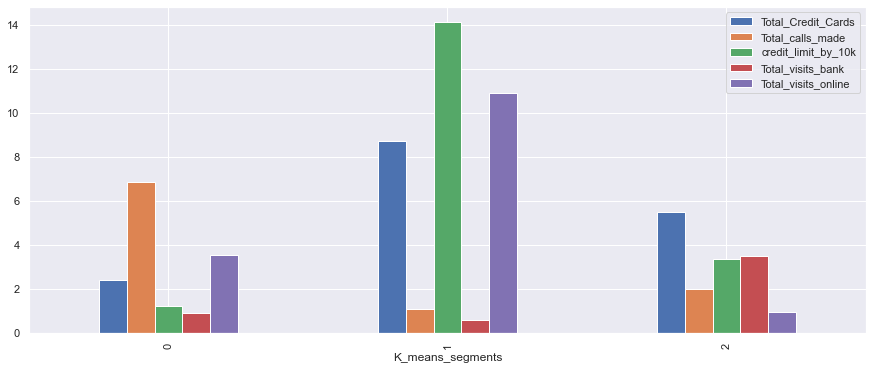

In [36]:
needed_cols_w_scaled_credit = list(set([s for s in needed_cols if s != 'Avg_Credit_Limit'] + ['credit_limit_by_10k']))
df[needed_cols_w_scaled_credit].groupby(segment_col_of_interest).mean().plot.bar(figsize=(15,6));

We can now see more than just the credit limit.

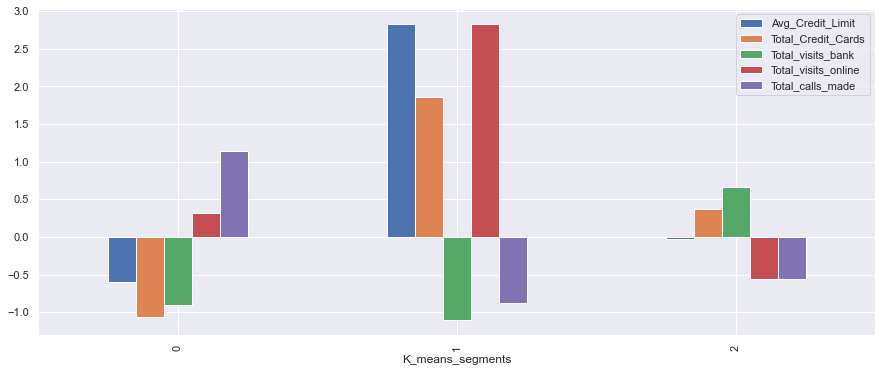

In [37]:
# Another way to look at things is to use the z-score scaled variables so they are all viewed on the same score
#   The plus in this method is the ease of seeing if something is above or below average (+/- 0)
#   The minus is that it isn't readily interpretable beyond that (What does the almost 3x standard deviation
#   of the credit limit equate to?)
scaled_df[segment_col_of_interest] = kmeans.labels_
scaled_cluster_profile = scaled_df[needed_cols].groupby(segment_col_of_interest).mean()
scaled_cluster_profile['count_in_each_segment'] = scaled_df[needed_cols].groupby(segment_col_of_interest)[scaled_df[needed_cols].columns[0]].count().values
scaled_cluster_profile

scaled_df[needed_cols].groupby(segment_col_of_interest).mean().plot.bar(figsize=(15,6));

### Derive Insights

For the k-means clusters:

Cluster 0: (n = 224)
- These individuals have the lowest credit limit (~$12k)
- In this cluster, the total number of credit cards is the lowest. (~2)
- Bank visits are below average in this group (<1)
- Online visits are above average in this group (~ 4)
- Calls are the highest in this group at nearly 7!

Cluster 1: (n = 50)
- These individuals have the highest credit limit (~$140k)
- These have the highest number of credit cards. (~9)
- This group has the lowest number of bank visits (<1)
- This group is the most active online. (11 page visits)
- This group makes the least number of calls. (~1)

Cluster 2: (n = 386)
- These individuals have an average credit limit (~$34k)
- These have a slightly above average number of credit cards. (~6)
- This group has the highest number of bank visits. (~3)
- This group is the least active online. (<1 page visit)
- This group makes a below average number of calls. (2)

### Perform cluster profiling - for Hierachical Clusters

In [38]:
HCmodel = AgglomerativeClustering(n_clusters=hier_cluster_number,affinity='euclidean', linkage=best_linkage_type)
HCmodel.fit(scaled_df[scaled_df.columns.to_list()[0:5]])

AgglomerativeClustering(linkage='average')

In [39]:
segment_col_of_interest = 'HC_Clusters'
needed_cols = list(features + [segment_col_of_interest])

scaled_df[segment_col_of_interest] = HCmodel.labels_
df[segment_col_of_interest] = HCmodel.labels_
cluster_profile = df[needed_cols].groupby(segment_col_of_interest).mean()
# Since this is a count, it doesn't really matter which column is chosen.  I therefore generalized this code.
cluster_profile['count_in_each_segment'] = df[needed_cols].groupby(segment_col_of_interest)[df[needed_cols].columns[0]].count().values

display(cluster_profile)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
HC_Clusters,,,,,,
0,25847.540984,4.37541,2.55082,1.92623,3.788525,610
1,141040.000000,8.74000,0.60000,10.90000,1.080000,50


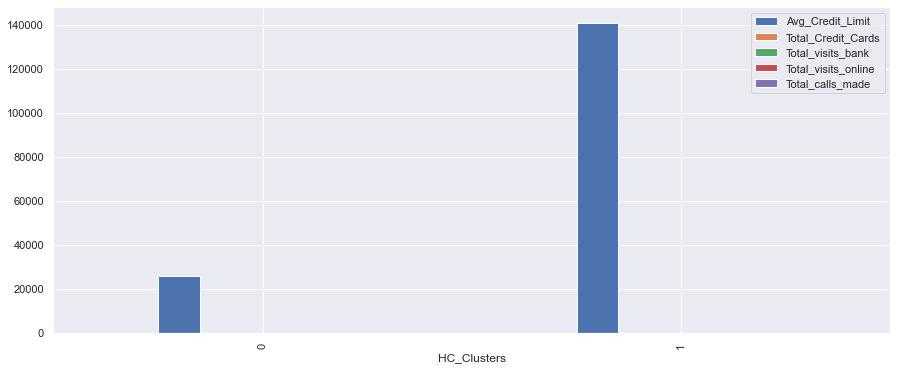

In [40]:
df[needed_cols].groupby(segment_col_of_interest).mean().plot.bar(figsize=(15,6));

From this, we can really only make comments on the credit limit.  Due to its sheer magnitude, it crowds out the others.

We can see that segment 1 is for the 'high rollers'; segment 0, 'the rest'

So, I will do a simple rescaling of just that Avg Credit limit variable by dividing it by 10,000 in order to see everything at the same time.

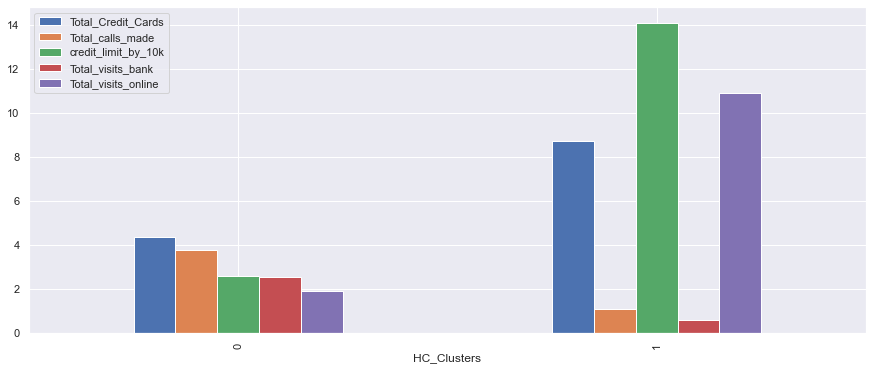

In [41]:
# re-using the x/10,000 scaled variable for the credit limit.
needed_cols_w_scaled_credit = list(set([s for s in needed_cols if s != 'Avg_Credit_Limit'] + ['credit_limit_by_10k']))
df[needed_cols_w_scaled_credit].groupby(segment_col_of_interest).mean().plot.bar(figsize=(15,6));

We can again see more now than just the credit limit.

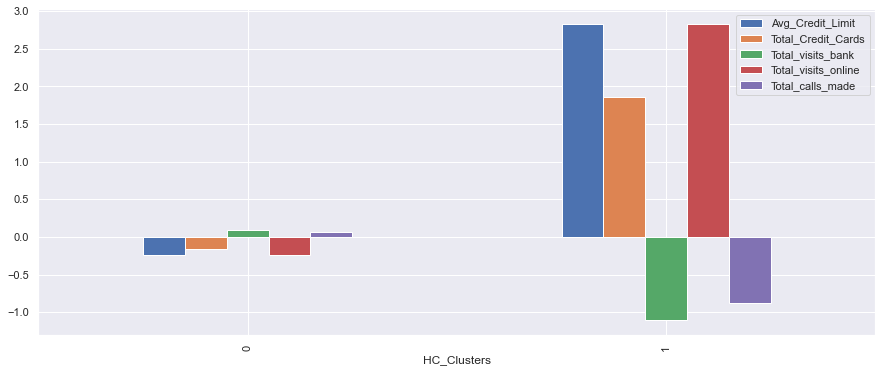

In [42]:
# Another way to look at things is to use the z-score scaled variables so they are all viewed on the same score
#   The plus in this method is the ease of seeing if something is above or below average (+/- 0)
#   The minus is that it isn't readily interpretable beyond that (What does the almost 3x standard deviation
#   of the credit limit equate to?)

scaled_cluster_profile = scaled_df[needed_cols].groupby(segment_col_of_interest).mean()
scaled_cluster_profile['count_in_each_segment'] = scaled_df[needed_cols].groupby(segment_col_of_interest)[scaled_df[needed_cols].columns[0]].count().values
scaled_cluster_profile

scaled_df[needed_cols].groupby(segment_col_of_interest).mean().plot.bar(figsize=(15,6));

### Derive Insights

For the hierachical clusters, we now have two clusters, a high-end cluster and a low end cluster.

Cluster 0: (n = 610)
- These individuals have the lowest credit limit (~$26k)
- In this cluster, the total number of credit cards is the lowest. (~4)
- Bank visits are a little above average in this group (~3)
- Online visits are below average in this group (~2)
- Calls are the highest in this group at nearly 4

Cluster 1: (n = 50)
- These individuals have the highest credit limit (~$140k)
- These have the highest number of credit cards. (~9)
- This group has the lowest number of bank visits (<1)
- This group is the most active online. (11 page visits)
- This group makes the least number of calls. (~1)

### Insights about different clusters

An interesting thing about the 2 clusters here is that the high-roller cluster (cluster 1) has all of the extreme values in terms of the large-magnitude z-scores.  The other cluster (cluster 0) has everything right about the mean.  I suppose that makes sense because cluster 1 only has 50 people, while cluster 0 has 610 people.  Thus, the values that are in cluster 0 are essentially the mean since they represent 92.4% of the customers here.

### Compare clusters obtained from k-means and hierarchical clustering techniques

In [43]:
print("I chose {0} as the optimal number of clusters for k-means.\n".format(kmeans_cluster_number)+
      "I chose {0} as the optimal of clusters for hierarchical clustering.".format(hier_cluster_number))

I chose 3 as the optimal number of clusters for k-means.
I chose 2 as the optimal of clusters for hierarchical clustering.


One thing that is very interesting about this data is how strong the clusters are.  The lectures, the notes, and outside reading material all stress the point that you may not come up with the same clustering if you use hierachical clusters that you would if you used k-means.  In fact, the first paragraph of page 394 of <u>An Introduction to Statistical Learning with Applications in R</u> reads:

> "The term hierarchical refers to the fact that clusters obtained by cutting
the dendrogram at a given height are necessarily nested within the clusters
obtained by cutting the dendrogram at any greater height. However, on
an arbitrary data set, this assumption of hierarchical structure might be
unrealistic. For instance, suppose that our observations correspond to a
group of people with a 50–50 split of males and females, evenly split among
Americans, Japanese, and French. We can imagine a scenario in which the
best division into two groups might split these people by gender, and the
best division into three groups might split them by nationality. In this case,
the true clusters are not nested, in the sense that the best division into three
groups does not result from taking the best division into two groups and
splitting up one of those groups. Consequently, this situation could not be
well-represented by hierarchical clustering. Due to situations such as this
one, hierarchical clustering can sometimes yield worse (i.e. less accurate)
results than K-means clustering for a given number of clusters."

What's interesting is that the number of people in cluster 1 of the hierarchical-clustering is exactly equal to cluster 1 of k-means (n=50).  That leads me to believe that this is a very strong cluster, and that the other clusters (0 and 2) of the k-means clusters are nested within the other cluster (cluster 0) of the hierarchical clustering.

After this block, I'll take a peek at that.  The only other insight to draw from this comparison exercise is that, since the "high-roller" cluster popped out using both clustering techniques, the "other" cluster is just an average of those other two k-means clusters.

In [44]:
# Just peeking at what k = 3 looks like
HCmodel = AgglomerativeClustering(n_clusters=3,affinity='euclidean', linkage=best_linkage_type)
HCmodel.fit(scaled_df[scaled_df.columns.to_list()[0:5]])

AgglomerativeClustering(linkage='average', n_clusters=3)

In [45]:
segment_col_of_interest = 'HC_Clusters_3'
needed_cols = list(features + [segment_col_of_interest])

scaled_df[segment_col_of_interest] = HCmodel.labels_
df[segment_col_of_interest] = HCmodel.labels_
cluster_profile = df[needed_cols].groupby(segment_col_of_interest).mean()
# Since this is a count, it doesn't really matter which column is chosen.  I therefore generalized this code.
cluster_profile['count_in_each_segment'] = df[needed_cols].groupby(segment_col_of_interest)[df[needed_cols].columns[0]].count().values

display(cluster_profile)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
HC_Clusters_3,,,,,,
0,33713.178295,5.511628,3.485788,0.984496,2.005168,387
1,141040.000000,8.740000,0.600000,10.900000,1.080000,50
2,12197.309417,2.403587,0.928251,3.560538,6.883408,223


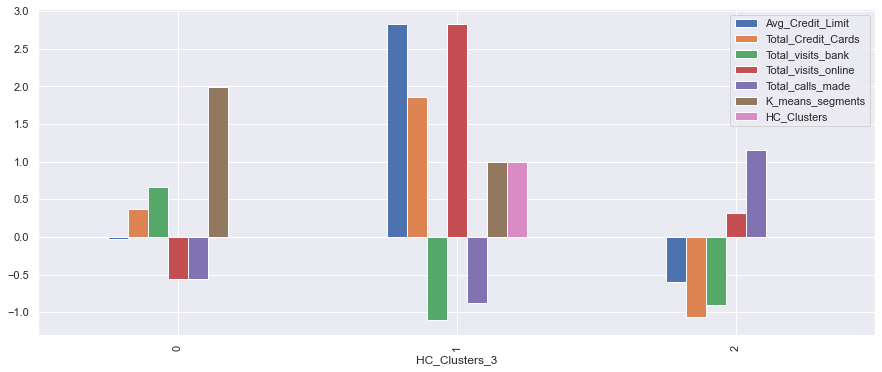

In [46]:
scaled_cluster_profile = scaled_df.groupby('HC_Clusters_3').mean()
scaled_cluster_profile['count_in_each_segment'] = scaled_df.groupby('HC_Clusters_3')[scaled_df.columns[0]].count().values
scaled_cluster_profile

scaled_df.groupby('HC_Clusters_3').mean().plot.bar(figsize=(15,6));

In [47]:
no_high_rollers = df.loc[df['HC_Clusters_3'] != 1,['K_means_segments', 'HC_Clusters_3']].reset_index()
all_rollers = df[['K_means_segments', 'HC_Clusters_3']].reset_index()

In [48]:
# I wanted to check to see if all the customers in HC_Clusters == 1 stayed there.  They did.
# all_all_rollers.groupby(['K_means_segments', 'HC_Clusters_3', 'HC_Clusters']).count()

In [49]:
# I wanted to see if none of the HC_Clusters_3 == 1 values were a problem.  That checked out as well.
# all_rollers.groupby(['HC_Clusters_3', 'K_means_segments']).count()

In [50]:
no_high_rollers.groupby(['HC_Clusters_3', 'K_means_segments']).count()

index
HC_Clusters_3 K_means_segments       
0             0                     1
              2                   386
2             0                   223

Here we can see that the hierachical clustering (k=3) didn't perfectly split its "other" group into clusters 1 and 3 from the k-means. Its clustering put one single customer into a different cluster than the k-means clustering (k=3) would have.  That's some pretty great nesting.

This dataset is pretty well formulated for clustering when the hierachical and kmeans clusters come out that closely.

## Actionable Insights & Recommendations

### Conclude with the key takeaways for the business

1.  Keep your website available and accurate.  Your 50 highest-credit customers are all heavy web users.
2.  We should market high credit limit products on the web or through email since that is where our most lucrative customers are.
3.  The users of our physical banks have average credit.  We should maintain our working hours or see if there are evenings we can stay open later to cater to this large segment of our bank.
4.  We should market to this group with in-bank signage or with billboards near the bank.  We could also put billboards near other bank franchises to lure their in-person customer group.
5.  The heavy users of our call center have the lowest credit.  We should find out if this group of customers is still profitable to the bank.
6.  If they are still profitable to the bank (even marginally, since this is a large cohort of customers), we should staff our call center well so that hold times are acceptable.
7.  If we wish to grow this call-centric group, we should probably reach them by telemarketing.

### What would be your business recommendation

In short, our best customers are online customers, so digital targeted ads will likely yield the customer group with the highest credit.

## Notebook - Overall
### Structure and flow

##### I built this structure and flow around the description of the problem.
1. First, I copied that text into an rtf.  Then, I formatted it as a markdown document.
2. Next, I created the shell of a jupyter notebook with one large markdown cell.   
3. After that, I split the markdown cell into discrete text chunks.
4. Finally, I inserted a blank code cell between each header or sub-header as a sort of fill-in-the-blanks jupyter worksheet to make sure I didn't miss any salient points.

### Well-commented code

In [51]:
# I hope my code makes sense to the graders, to my future self, and to anyone else looking at this jupyter notebook.

#### **Scoring guide (Rubric) - Customer Segmentation**

| <u> Criteria </u>  | <u> Points </u> |
|-----------| ---------|
|  <center><b> Define the problem and perform an Exploratory Data Analysis </b></b></center>|  |
| Problem definition, questions to be answered - Data background and contents - Univariate analysis - Bivariate analysis | 8 |
| <center><b> Illustrate the insights based on EDA  </center>| |
| Key meaningful observations on individual variables and the relationship between variables | 7 |
| <center><b> Data pre-processing </b></center>| |
| Prepare the data for analysis - Feature Engineering - Missing value Treatment - Outlier Treatment - Duplicate observations check and removal if found | 5 |
| <center><b> Applying K-means clustering algorithms </b></center>| |
| Apply K-means - Elbow curve - Silhouette Score - figure out appropriate number of cluster | 10 |
| <center><b> Applying Hierarchical clustering </b></center>| |
| Apply Hierarchical clustering with different linkage methods - Plot dendrograms for each linkage methods - Choose appropriate number of cluster | 10 |
| <center><b> Compare cluster K-means clusters and Hierarchical clusters - Perform cluster profiling - Derive Insights </b></center>| |
| Compare clusters obtained from k-means and hierarchical clustering techniques - Perform cluster profiling - Insights about different clusters | 10 |
| <center><b> Actionable Insights & Recommendations </b></center>| |
| Conclude with the key takeaways for the business - What would your buisness recommendation." | 5 |
| <center><b> Notebook - Overall </b></center>| |
| Structure and flow - Well commented code | 5 |
|Total Points | 60 |